In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix

import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from torch_geometric.nn import GCNConv, GATConv, GATv2Conv

/Users/mohit/opt/anaconda3/envs/exp_pytorch_only/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder='elliptic_dataset/'

In [3]:
!mkdir save_results

# load python files from foldername
import sys
sys.path.append(folder)
%load_ext autoreload
%autoreload 2

mkdir: save_results: File exists


In [4]:
# df_features1=pd.read_csv(folder+'/elliptic_txs_features.csv')
# df_features1

In [5]:
df_features=pd.read_csv(folder+'elliptic_txs_features.csv',header=None)
df_features

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.135803,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.156418,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,-0.163626,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163501,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [6]:
df_edges=pd.read_csv(folder+'elliptic_txs_edgelist.csv')
df_edges

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [7]:
df_classes=pd.read_csv(folder+'elliptic_txs_classes.csv')
df_classes

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown
...,...,...
203764,173077460,unknown
203765,158577750,unknown
203766,158375402,1
203767,158654197,unknown


In [8]:
df_classes['class']=df_classes['class'].map({'unknown':2,'1':1,'2':0})
df_classes

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2
...,...,...
203764,173077460,2
203765,158577750,2
203766,158375402,1
203767,158654197,2


In [9]:
group_class=df_classes.groupby('class').count()
group_class

,txId
class,
0,42019
1,4545
2,157205


In [10]:
group_class['txId'].values

array([ 42019,   4545, 157205])

<BarContainer object of 3 artists>

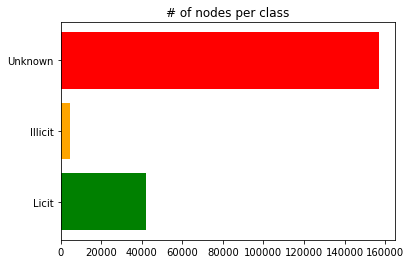

In [11]:
plt.title('# of nodes per class')
plt.barh(['Licit', 'Illicit', 'Unknown'], group_class['txId'].values, color=['g','orange','r'])

In [12]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [13]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [14]:
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


In [15]:
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [16]:
df_merge=df_features.merge(df_classes,how='left',right_on='txId',left_on=0)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,0
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2


In [17]:
df_merge=df_merge.sort_values(0)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
199861,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
31635,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
133793,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
2945,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
198375,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [18]:
df_merge=df_merge.reset_index(drop=True)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [19]:
nodes=df_merge[0].values
nodes

array([     1076,      2534,      3181, ..., 403234715, 403235564,
       403244581])

In [20]:
map_id={j:i for i,j in enumerate(nodes)}
map_id

{1076: 0,
 2534: 1,
 3181: 2,
 3321: 3,
 3889: 4,
 5473: 5,
 6415: 6,
 6418: 7,
 7952: 8,
 7954: 9,
 9334: 10,
 9351: 11,
 9363: 12,
 9372: 13,
 9379: 14,
 9381: 15,
 9460: 16,
 9466: 17,
 9551: 18,
 9562: 19,
 10247: 20,
 10254: 21,
 10280: 22,
 10452: 23,
 11108: 24,
 11597: 25,
 11638: 26,
 12051: 27,
 12068: 28,
 13646: 29,
 16134: 30,
 16421: 31,
 17122: 32,
 18589: 33,
 18810: 34,
 28907: 35,
 29253: 36,
 29272: 37,
 29339: 38,
 29777: 39,
 29786: 40,
 32496: 41,
 33775: 42,
 39370: 43,
 39382: 44,
 39994: 45,
 44658: 46,
 44664: 47,
 44703: 48,
 45096: 49,
 45294: 50,
 45766: 51,
 47299: 52,
 47414: 53,
 51816: 54,
 52635: 55,
 58945: 56,
 60857: 57,
 62455: 58,
 65253: 59,
 65879: 60,
 68869: 61,
 70875: 62,
 71198: 63,
 71201: 64,
 72958: 65,
 73958: 66,
 74044: 67,
 75160: 68,
 75163: 69,
 75165: 70,
 84810: 71,
 87778: 72,
 89273: 73,
 96910: 74,
 102570: 75,
 104216: 76,
 113780: 77,
 121630: 78,
 121959: 79,
 122326: 80,
 127339: 81,
 127342: 82,
 130932: 83,
 132791: 84,


In [21]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [22]:
edges=df_edges.copy()
edges

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


In [23]:
map_id[230425980]

138670

In [24]:
edges.txId1=edges.txId1.map(map_id)
edges.head()

,txId1,txId2
0,138670,5530458
1,141325,232438397
2,139232,230459870
3,138150,230595899
4,141268,232029206


In [25]:
map_id[5530458]

4142

In [26]:
edges.txId2=edges.txId2.map(map_id)
edges.head()

,txId1,txId2
0,138670,4142
1,141325,142201
2,139232,139223
3,138150,140289
4,141268,141368


In [27]:
edges=edges.astype(int)
edges.head()

,txId1,txId2
0,138670,4142
1,141325,142201
2,139232,139223
3,138150,140289
4,141268,141368


In [28]:
edges.values

array([[138670,   4142],
       [141325, 142201],
       [139232, 139223],
       ...,
       [100420, 100419],
       [ 54833,  81951],
       [101159, 101163]])

In [29]:
edges.values.shape

(234355, 2)

In [30]:
edge_index=np.array(edges.values).T
edge_index

array([[138670, 141325, 139232, ..., 100420,  54833, 101159],
       [  4142, 142201, 139223, ..., 100419,  81951, 101163]])

In [31]:
edge_index.shape

(2, 234355)

In [32]:
edge_index=torch.tensor(edge_index, dtype=torch.long)
edge_index

tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [33]:
edge_index=edge_index.contiguous()
edge_index

tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [34]:
print(edge_index.shape)

torch.Size([2, 234355])


In [35]:
print(edge_index.shape[1])

234355


In [36]:
weights=torch.tensor([1]*edge_index.shape[1], dtype=torch.double)
weights

tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64)

In [37]:
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [38]:
labels=df_merge['class'].values
print('labels', np.unique(labels))
labels

labels [0 1 2]


array([2, 0, 0, ..., 2, 2, 2])

In [39]:
node_features=df_merge.drop(['txId'],axis=1).copy()
node_features.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,2


In [40]:
print('unique=',node_features['class'].unique())

unique= [2 0 1]


In [41]:
node_features['class']

0         2
1         0
2         0
3         2
4         2
         ..
203764    2
203765    2
203766    2
203767    2
203768    2
Name: class, Length: 203769, dtype: int64

In [42]:
classified_idx1=node_features['class'].loc[node_features['class']!=2]
classified_idx1

1         0
2         0
7         0
8         0
11        0
         ..
203700    0
203709    0
203727    0
203743    0
203750    0
Name: class, Length: 46564, dtype: int64

In [43]:
classified_idx=node_features['class'].loc[node_features['class']!=2].index
classified_idx

Int64Index([     1,      2,      7,      8,     11,     12,     17,     18,
                22,     23,
            ...
            203678, 203679, 203681, 203698, 203699, 203700, 203709, 203727,
            203743, 203750],
           dtype='int64', length=46564)

In [44]:
unclassified_idx=node_features['class'].loc[node_features['class']==2].index
unclassified_idx

Int64Index([     0,      3,      4,      5,      6,      9,     10,     13,
                14,     15,
            ...
            203759, 203760, 203761, 203762, 203763, 203764, 203765, 203766,
            203767, 203768],
           dtype='int64', length=157205)

In [45]:
classified_illicit_idx=node_features['class'].loc[node_features['class']==1].index
classified_illicit_idx

Int64Index([   849,   1115,   1331,   1351,   1356,   1773,   1820,   2613,
              2718,   2719,
            ...
            202841, 202867, 202868, 202869, 203205, 203273, 203274, 203482,
            203698, 203699],
           dtype='int64', length=4545)

In [46]:
classified_licit_idx=node_features['class'].loc[node_features['class']==0].index
classified_licit_idx

Int64Index([     1,      2,      7,      8,     11,     12,     17,     18,
                22,     23,
            ...
            203676, 203677, 203678, 203679, 203681, 203700, 203709, 203727,
            203743, 203750],
           dtype='int64', length=42019)

In [47]:
node_features.head()

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,2


In [48]:
node_features=node_features.drop(columns=[0,1,'class'])
node_features.head()

,2,3,4,5,6,7,8,9,10,11,...,157,158,159,160,161,162,163,164,165,166
0,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,-0.164980,-0.009283,...,0.073047,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399
1,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,-0.167757,-0.038545,...,1.228858,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288
2,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,1.321754,-0.049707,...,1.348450,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772
3,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,-0.166062,-0.049707,...,-0.577099,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
4,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,-0.081943,-0.049707,...,0.501062,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601


In [49]:
node_features.values

array([[-0.16849973,  0.27090894, -0.09138345, ...,  1.15160746,
         1.51969962,  1.52139948],
       [-0.17083402, -0.13142464,  1.0186019 , ..., -0.12213701,
        -0.37996967, -0.37928769],
       [ 1.30521167, -0.21055258, -1.75636148, ..., -0.13101025,
         0.00699431,  0.0177724 ],
       ...,
       [-0.17266855, -0.15878252, -1.2013688 , ..., -0.26981753,
        -0.12061341, -0.11979246],
       [-0.17266855, -0.15878252, -1.2013688 , ..., -0.26981753,
        -0.12061341, -0.11979246],
       [-0.14329174, -0.15878252, -1.2013688 , ..., -0.09752359,
        -0.12061341, -0.11979246]])

In [50]:
node_features_t=torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)
node_features_t

tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

In [51]:
node_features.shape

(203769, 165)

In [52]:
node_features

,2,3,4,5,6,7,8,9,10,11,...,157,158,159,160,161,162,163,164,165,166
0,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,-0.164980,-0.009283,...,0.073047,-0.039637,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399
1,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,-0.167757,-0.038545,...,1.228858,0.379357,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288
2,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,1.321754,-0.049707,...,1.348450,1.590664,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772
3,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,-0.166062,-0.049707,...,-0.577099,-0.500080,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399
4,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,-0.081943,-0.049707,...,0.501062,0.362510,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,-0.172978,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163640,-0.169455,-0.049707,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,-0.169142,-0.049707,...,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792
203766,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,-0.169142,-0.049707,...,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792
203767,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,-0.169142,-0.049707,...,-0.577099,-0.626229,0.241128,0.241406,-0.216057,-0.125939,-0.131155,-0.269818,-0.120613,-0.119792


In [53]:
classified_idx

Int64Index([     1,      2,      7,      8,     11,     12,     17,     18,
                22,     23,
            ...
            203678, 203679, 203681, 203698, 203699, 203700, 203709, 203727,
            203743, 203750],
           dtype='int64', length=46564)

In [54]:
classified_idx.values

array([     1,      2,      7, ..., 203727, 203743, 203750])

In [55]:
train_idx, valid_idx=train_test_split(classified_idx.values,test_size=0.15)
print('train_idx size {}'.format(len(train_idx)))
print('test_idx size {}'.format(len(valid_idx)))

train_idx size 39579
test_idx size 6985


In [56]:
labels

array([2, 0, 0, ..., 2, 2, 2])

In [57]:
labels.shape

(203769,)

In [58]:
weights

tensor([1., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64)

In [59]:
weights.shape

torch.Size([234355])

In [60]:
edge_index

tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [61]:
print(train_idx)
print()
print(valid_idx)
print()
print(unclassified_idx)

[123521 177431 133002 ...   5152  47352  88383]

[ 17603 185876 145112 ...  61612  90663  18701]

Int64Index([     0,      3,      4,      5,      6,      9,     10,     13,
                14,     15,
            ...
            203759, 203760, 203761, 203762, 203763, 203764, 203765, 203766,
            203767, 203768],
           dtype='int64', length=157205)


In [62]:
print(edge_index.dtype)

torch.int64


In [63]:
data_train=Data(x=node_features_t, edge_index=edge_index, edge_attr=weights, y=torch.tensor(labels, dtype=torch.double))
data_train.train_idx=train_idx
data_train.valid_idx=valid_idx
data_train.test_idx=unclassified_idx

In [64]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
import pickle

In [65]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1=GCNConv(165,128)
        self.conv2=GCN(128,2)
        self.classifier=Linear(2,1)
        
    def forward(self, data, adj=None):
        x, edge_index=data.x, data.edge_index
        h=self.conv1(x, edge_index)
        h=h.tanh()
        h=self.conv2(h, edge_index)
        embeddings=h.tanh()
        
        out=self.classifier(embeddings)
        
        return F.sigmoid(out)

In [66]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GAT, self).__init__()
        self.conv1=GATConv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2=GATConv(args['heads']*hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp=nn.Sequential(
                nn.Linear(args['heads']* hidden_dim, hidden_dim),
                nn.Dropout(args['dropout']),
                nn.Linear(hidden_dim, output_dim))
    
    def forward(self,data,adj=None):
        x, edge_index=data.x, data.edge_index
#         x=x.float()
        x=self.conv1(x, edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.conv2(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.post_mp(x)
        return F.sigmoid(x)
    

In [67]:
class GATv2(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GATv2, self).__init__()
        self.conv1=GATv2Conv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2=GATv2Conv(args['heads']*hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp=nn.Sequential(
                nn.Linear(args['heads']* hidden_dim, hidden_dim),
                nn.Dropout(args['dropout']),
                nn.Linear(hidden_dim, output_dim))
    
    def forward(self,data,adj=None):
        x, edge_index=data.x, data.edge_index
#         x=x.float()
        x=self.conv1(x, edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.conv2(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.post_mp(x)
        return F.sigmoid(x)

In [68]:
class myGAT(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, 
                negative_slope=0.2, dropout=0., **kwargs):
        super(myGAT,self).__init__(node_dim=0, **kwargs)
        
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.heads=heads
        self.negative_slope=negative_slope
        self.dropout=dropout
        
        self.lin_l=None
        self.lin_r=None
        self.att_l=None
        self.att_r=None
        
        self.lin_l=Linear(in_channels, heads*out_channels)
        self.lin_r=self.lin_l
        self.att_l=Parameter(torch.Tensor(1,heads,out_channels).float())
        self.att_r=Parameter(torch.Tensor(1,heads,out_channels).float())
#         self.att_l = Parameter(torch.Tensor(1, heads, out_channels).float())
#         self.att_r = Parameter(torch.Tensor(1, heads, out_channels).float())
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)
        
    def forward(self,x, edge_index, size=None):
        H, C = self.heads, self.out_channels
        
        x_source=self.lin_l(x).view(-1,H,C)
        x_target=self.lin_r(x).view(-1,H,C)
        
        alpha_l=(x_source*self.att_l).sum(dim=-1)
        alpha_r=(x_source*self.att_r).sum(dim=-1)
        
        out=self.propagate(edge_index, x=(x_source,x_target),alpha=(alpha_l,alpha_r), size=size)
        out=out.view(-1,self.heads*self.out_channels)
        
        return out
    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        attention=F.leaky_relu((alpha_j+alpha_i), self.negative_slope)
        attention=softmax(attention,index,ptr,size_i)
        attention=F.dropout(attention, p=self.dropout, training=self.training)
        
        out=x_j*attention.unsqueeze(-1)
        return out
    
    def aggregate(self, inputs, index, dim_size=None):
        out=torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')
        return out
        

In [69]:
class myGATv2(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, negative_slope=0.2, dropout=0., **kwargs ):
        super(myGATv2,self).__init__(node_dim=0, **kwargs)
        
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.heads=heads
        self.negative_slope=negative_slope
        self.dropout=dropout
        
        self.lin_l=None
        self.lin_r=None
        self.att_l=None
        self.att_r=None
        self._alpha=None
        
        self.lin_l=Linear(in_channels,heads*out_channels)
        self.lin_r=self.lin_l
        
        self.att=Parameter(torch.Tensor(1,heads,out_channels))
        self.reset_parameters()
#     def __init__(self, in_channels, out_channels, heads = 1,
#                  negative_slope = 0.2, dropout = 0., **kwargs):
#         super(myGATv2, self).__init__(node_dim=0, **kwargs)

#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.heads = heads
#         self.negative_slope = negative_slope
#         self.dropout = dropout

#         self.lin_l = None
#         self.lin_r = None
#         self.att_l = None
#         self.att_r = None
#         self._alpha = None
#         # self.lin_l is the linear transformation that you apply to embeddings 
#         # BEFORE message passing.
#         self.lin_l =  Linear(in_channels, heads*out_channels)
#         self.lin_r = self.lin_l

#         self.att = Parameter(torch.Tensor(1, heads, out_channels))
#         self.reset_parameters()
#     def reset_parameters(self):
#         nn.init.xavier_uniform_(self.lin_l.weight)
#         nn.init.xavier_uniform_(self.lin_r.weight)
#         nn.init.xavier_uniform_(self.att)
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att)     
#     def forward(self, x, edge_index, size=None):
#         H,C = self.heads, self.out_channels
        
#         x_source=self.lin_l(x).view(-1,H,C)
#         x_target=self.lin_r(x).view(-1,H,C)
        
#         out=self.propagate(edge_index, x=(x_source,x_target), size=size)
#         out=out.view(-1,self.heads*self.out_channels)
        
#         alpha=self._alpha
#         self.alpha=None
#         return out
    
    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels # DIM：H, outC
        #Linearly transform node feature matrix.
        x_source = self.lin_l(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        x_target = self.lin_r(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        
        #  Start propagating messages (runs message and aggregate)
        out= self.propagate(edge_index, x=(x_source,x_target),size=size) # DIM: [nodes, H, outC]
        out= out.view(-1, self.heads * self.out_channels)       # DIM: [nodes, H * outC]
        alpha = self._alpha
        self._alpha = None
        return out
    
    def message(self, x_j, x_i, index, ptr, size_i):
        x=x_i + x_j
        x=F.leaky_relu(x, self.negative_slope)
        alpha=(x*self.att).sum(dim=-1)
        alpha=softmax(alpha, index, ptr, size_i)
        self._alpha=alpha
        
        alpha=F.dropout(alpha,p=self.dropout, training=self.training)
        
        out=x_j*alpha.unsqueeze(-1)
        
        return out
    
    def aggregate(self, inputs, index, dim_size=None):
        out=torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')
        
        return out
    

In [70]:
class GATmodif(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GATmodif, self).__init__()
        
        self.conv1=myGAT(input_dim, hidden_dim, heads=args['heads'])
        self.conv2=myGAT(args['heads']*hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp=nn.Sequential(
                        nn.Linear(args['heads']*hidden_dim,hidden_dim),
                        nn.Dropout(args['dropout']),
                        nn.Linear(hidden_dim,output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index=data.x, data.edge_index
        
        x=self.conv1(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.conv2(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.post_mp(x)
        return F.sigmoid(x)
    
class GATv2modif(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GATv2modif, self).__init__()
        
        self.conv1=myGATv2(input_dim, hidden_dim, heads=args['heads'])
        self.conv2=myGATv2(args['heads']*hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp=nn.Sequential(
                        nn.Linear(args['heads']*hidden_dim,hidden_dim),
                        nn.Dropout(args['dropout']),
                        nn.Linear(hidden_dim,output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index=data.x, data.edge_index
        
        x=self.conv1(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.conv2(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.post_mp(x)
        return F.sigmoid(x)

class GATmodif_3layer(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GATmodif_3layer, self).__init__()
        
        self.conv1=myGAT(input_dim, hidden_dim, heads=args['heads'])
        self.conv2=myGAT(args['heads']*hidden_dim, hidden_dim, heads=args['heads'])
        self.conv3=myGAT(args['heads']*hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp=nn.Sequential(
                        nn.Linear(args['heads']*hidden_dim,hidden_dim),
                        nn.Dropout(args['dropout']),
                        nn.Linear(hidden_dim,output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index=data.x, data.edge_index
        
        x=self.conv1(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.conv2(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.conv3(x,edge_index)
        x=F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        x=self.post_mp(x)
        return F.sigmoid(x)

In [71]:
class GnnTrainer(object):
    def __init__(self, model):
        self.model=model
        self.metric_manager =MetricManager(modes=['train','val'])
    
    def train(self, data_train, optimizer, criterion, scheduler, args):
        self.data_train=data_train
        
        for epoch in range(args['epochs']):
            self.model.train()
            optimizer.zero_grad()
            out=self.model(data_train)
            
            out=out.reshape((data_train.x.shape[0]))
            loss=criterion(out[data_train.train_idx], data_train.y[data_train.train_idx])
            
            target_labels=data_train.y.detach().cpu().numpy()[data_train.train_idx]
            pred_scores=out.detach().cpu().numpy()[data_train.train_idx]
            train_acc, train_f1, train_f1macro, train_aucroc, train_recall, train_precision, train_cm=self.metric_manager.store_metrics('train', pred_scores, target_labels)
            
            loss.backward()
            optimizer.step()
            
            self.model.eval()
            target_labels=data_train.y.detach().cpu().numpy()[data_train.valid_idx]
            pred_scores=out.detach().cpu().numpy()[data_train.valid_idx]
#             val_acc, val_f1, val_f1macro, val_aucroc, val_recall, val_precision, val_cm=self.metric_manager.store_metrics('val', pred_scores, target_labels)
            val_acc, val_f1,val_f1macro, val_aucroc, val_recall, val_precision, val_cm = self.metric_manager.store_metrics("val", pred_scores, target_labels)
#             print(epoch)
            print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} -accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, loss.item(), train_acc, val_acc, val_aucroc,val_f1))
    
#         if epoch%5 == 0:
#                   print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} -accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, loss.item(), train_acc, val_acc, val_aucroc,val_f1))
            
    def predict(self, data=None, unclassified_only=True, threshold=0.5):
            self.model.eval()
            
            if data is not None:
                self.data_train=data
            
            out=self.model(self.data_train)
            out=out.reshape((self.data_train.x.shape[0]))
            
            if unclassified_only:
                pred_scores=out.detach().cpu().numpy()[self.data_train.test_idx]
            else:
                pred_scores=out.detach().cpu().numpy()
            
            pred_labels=pred_scores>threshold
            
            return {'pred_scores': pred_scores, 'pred_labels': pred_labels}
    
    
    
    def save_metrics(self, save_name, path="./save/"):
            print('king')
            file_to_store = open(path+save_name, "wb")
            pickle.dump(self.metric_manager, file_to_store)
            file_to_store.close()      
#         def save_metrics(self, save_name, path='./save/'):
#             file_to_store=open(path+save_name,'wb')
#             pickle.dump(self.metric_manager, file_to_store)
#             file_to_store.close()
          
    def save_model(self, save_name, path='./save/'):
            torch.save(self.model.state_dict(), path+save_name)
        

In [72]:
class MetricManager(object):
    def __init__(self, modes=["train", "val"]):
#     def __init__(self, modes=['train','val']):
#         self.output={}
        self.output = {}
        
        for mode in modes:
#             self.output[mode]={}
#             self.output[mode]['accuracy']=[]
#             self.output[mode]['f1micro']=[]
#             self.output[mode]['f1macro']=[]
#             self.output[mode]['aucroc']=[]
            self.output[mode] = {}
            self.output[mode]["accuracy"] = []
            self.output[mode]["f1micro"] = []
            self.output[mode]["f1macro"] = []
            self.output[mode]["aucroc"] = []
            
#             self.output[mode]['precision']=[]
#             self.output[mode]['recall']=[]
#             self.output[mode]['cm']=[]
            self.output[mode]["precision"] = []
            self.output[mode]["recall"] = []
            self.output[mode]["cm"] = []
    
    def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):
        
#         pred_labels=pred_scores>threshold
#         accuracy=accuracy_score(target_labels, pred_labels)
#         f1micro=f1_score(target_labels, pred_labels, average='micro')
#         f1macro=f1_score(target_labels, pred_labels, average='macro')
#         aucroc=roc_auc_score(target_labels, pred_scores)
        
        pred_labels = pred_scores > threshold
        accuracy = accuracy_score(target_labels, pred_labels)
        f1micro = f1_score(target_labels, pred_labels,average='micro')
        f1macro = f1_score(target_labels, pred_labels,average='macro')
        aucroc = roc_auc_score(target_labels, pred_scores)
        
#         recall=recall_score(target_labels, pred_labels)
#         precision=precision_score(target_labels, pred_labels)
#         cm=confusion_matrix(target_labels, pred_labels)
        
        recall = recall_score(target_labels, pred_labels)
        precision = precision_score(target_labels, pred_labels)
        cm = confusion_matrix(target_labels, pred_labels)
        
#         self.output[mode]['accuracy'].append(accuracy)
#         self.output[mode]['f1micro'].append(f1micro)
#         self.output[mode]['f1macro'].append(f1macro)
#         self.output[mode]['aucroc'].append(aucroc)
        
        self.output[mode]["accuracy"].append(accuracy)
        self.output[mode]["f1micro"].append(f1micro)
        self.output[mode]["f1macro"].append(f1macro)
        self.output[mode]["aucroc"].append(aucroc)
        
#         self.output[mode]['precision'].append(precision)
#         self.output[mode]['recall'].append(recall)
#         self.output[mode]['cm'].append(cm)
        
        self.output[mode]["recall"].append(recall)
        self.output[mode]["precision"].append(precision)
        self.output[mode]["cm"].append(cm)
        
#         return accuracy, f1micro, f1macro, aucroc, recall, precision, cm
        return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
    
    def get_best(self, metric, mode='val'):
        
#         best_results={}
#         i=np.array(self.output[mode][metric]).argmax()
        
        best_results = {}
        i = np.array(self.output[mode][metric]).argmax()
        
#         for m in self.output[mode].keys():
#             best_results[m]=self.output[mode][m][i]
        
        for m in self.output[mode].keys():
            best_results[m] = self.output[mode][m][i]
            
#         return best_results    
        return best_results
        
        
        
        

In [73]:
args={'epochs':3,
      'lr':0.01,
      'weight_decay':1e-5,
      'prebuild':True,
      'heads':2,
      'hidden_dim':128,
      'dropout':0.5
      }

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [74]:
net='GAT'

if net=='GAT':
    if args['prebuild']==True:
        model=GAT(data_train.num_node_features, args['hidden_dim'],1,args)
        print('Prebuild GAT from PyG')
    else:
        model=GATmodif(data_train.num_node_features, args['hidden_dim'],1,args)
        print('Custom GAT implemented')
elif net=='GATv2':
    if args['prebuild']==True:
        model=GATv2(data_train.num_node_features, args['hidden_dim'],1,args)
        print('Prebuild GATv2 from PyG')
    else:
        model=GATv2modif(data_train.num_node_features, args['hidden_dim'],1,args)
        print('Custom GATv2 implemented')

model.double().to(device)        

Prebuild GAT from PyG


GAT(
  (conv1): GATConv(165, 128, heads=2)
  (conv2): GATConv(256, 128, heads=2)
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [75]:
print(device)

cpu


In [76]:
print(data_train.to(device))

Data(x=[203769, 165], edge_index=[2, 234355], edge_attr=[234355], y=[203769], train_idx=[39579], valid_idx=[6985], test_idx=Int64Index([     0,      3,      4,      5,      6,      9,     10,     13,
                14,     15,
            ...
            203759, 203760, 203761, 203762, 203763, 203764, 203765, 203766,
            203767, 203768],
           dtype='int64', length=157205))


In [77]:
# data_train=data_train.to(device)

# optimizer=torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
# scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# criterion=torch.nn.BCELoss()

# gnn_trainer_gat=GnnTrainer(model)
# gnn_trainer_gat.train(data_train, optimizer, criterion, scheduler, args)

# gnn_trainer_gat.save_metrics('GATprebuilt.results', path=folder+'/save_results/')
# gnn_trainer_gat.save_model('GATprebuilt.pth', path=folder+'/save_results/')

data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gat = GnnTrainer(model)
gnn_trainer_gat.train(data_train, optimizer, criterion, scheduler, args)



epoch: 0 - loss: 0.7770 - accuracy train: 0.5158 -accuracy valid: 0.5114  - val roc: 0.4612  - val f1micro: 0.5114
epoch: 1 - loss: 0.4879 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.8328  - val f1micro: 0.9015
epoch: 2 - loss: 0.4068 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.8742  - val f1micro: 0.9015


In [78]:
# !mkdir new_address

In [79]:
gnn_trainer_gat.save_metrics("GATprebuilt.results", path='./save_results/')
gnn_trainer_gat.save_model("GATprebuilt.pth", path="./save_results/")

king


In [80]:
model=GATv2(data_train.num_node_features, args['hidden_dim'],1,args)

model.double().to(device)

data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gatv2 = GnnTrainer(model)
gnn_trainer_gatv2.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gatv2.save_metrics("GATv2prebuilt.results", path='./save_results/')
gnn_trainer_gatv2.save_model("GATv2prebuilt.pth", path='./save_results/')

epoch: 0 - loss: 0.8512 - accuracy train: 0.3673 -accuracy valid: 0.3728  - val roc: 0.4406  - val f1micro: 0.3728
epoch: 1 - loss: 0.4464 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.8357  - val f1micro: 0.9015
epoch: 2 - loss: 0.3682 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.8629  - val f1micro: 0.9015
king


In [81]:
# model=GATmodif(data_train.num_node_features, args['hidden_dim'],1,args)

# model.double().to(device)

# data_train = data_train.to(device)

# # Setup training settings
# optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# criterion = torch.nn.BCELoss()

# # Train
# gnn_trainer_gatmodif = GnnTrainer(model)
# gnn_trainer_gatmodif.train(data_train, optimizer, criterion, scheduler, args)

#here we run GATmodif model
model = GATmodif(data_train.num_node_features, args['hidden_dim'], 1, args)
model.double().to(device)
# Push data to GPU
data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()
# Train
gnn_trainer_gatmodif = GnnTrainer(model)
gnn_trainer_gatmodif.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gatmodif.save_metrics("GATmodif.results", path='./save_results/')
gnn_trainer_gatmodif.save_model("GATmodif.pth", path='./save_results/')

epoch: 0 - loss: 0.7681 - accuracy train: 0.2618 -accuracy valid: 0.2681  - val roc: 0.5221  - val f1micro: 0.2681
epoch: 1 - loss: 0.6524 - accuracy train: 0.6727 -accuracy valid: 0.6752  - val roc: 0.5194  - val f1micro: 0.6752
epoch: 2 - loss: 0.6240 - accuracy train: 0.8820 -accuracy valid: 0.8848  - val roc: 0.5392  - val f1micro: 0.8848
king


In [82]:
model=GATv2modif(data_train.num_node_features, args['hidden_dim'],1,args)

model.double().to(device)

data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gatv2modif = GnnTrainer(model)
gnn_trainer_gatv2modif.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gatv2modif.save_metrics("GATv2modif.results", path='./save_results/')
gnn_trainer_gatv2modif.save_model("GATv2modif.pth", path='./save_results/')


epoch: 0 - loss: 0.7730 - accuracy train: 0.6803 -accuracy valid: 0.6785  - val roc: 0.5015  - val f1micro: 0.6785
epoch: 1 - loss: 0.6115 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.5056  - val f1micro: 0.9015
epoch: 2 - loss: 0.5916 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.5305  - val f1micro: 0.9015
king


In [83]:
model=GATmodif_3layer(data_train.num_node_features, args['hidden_dim'],1,args)

model.double().to(device)

data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gatmodif_3layer = GnnTrainer(model)
gnn_trainer_gatmodif_3layer.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gatmodif_3layer.save_metrics("GATmodif_3layer.results", path='./save_results/')
gnn_trainer_gatmodif_3layer.save_model("GATmodif_3layer.pth", path='./save_results/')

epoch: 0 - loss: 0.7364 - accuracy train: 0.6856 -accuracy valid: 0.6833  - val roc: 0.4973  - val f1micro: 0.6833
epoch: 1 - loss: 0.6287 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.4911  - val f1micro: 0.9015
epoch: 2 - loss: 0.5254 - accuracy train: 0.9025 -accuracy valid: 0.9015  - val roc: 0.5065  - val f1micro: 0.9015
king


In [86]:
fn="GATprebuilt.results"
mmGATprebuilt = pickle.load(open('./save_results/'+fn1,'rb'))
mmGATprebuilt.get_best("aucroc")



{'accuracy': 0.9015032211882605,
 'f1micro': 0.9015032211882607,
 'f1macro': 0.47410028610149074,
 'aucroc': 0.8742221286622275,
 'precision': 0.0,
 'recall': 0.0,
 'cm': array([[6297,    0],
        [ 688,    0]])}

In [87]:
fn='GATv2prebuilt.results'
mmGATv2prebuilt = pickle.load(open('./save_results/' + fn2, "rb"))
mmGATv2prebuilt.get_best("aucroc")

{'accuracy': 0.9015032211882605,
 'f1micro': 0.9015032211882607,
 'f1macro': 0.47410028610149074,
 'aucroc': 0.8629344538373755,
 'precision': 0.0,
 'recall': 0.0,
 'cm': array([[6297,    0],
        [ 688,    0]])}

In [102]:
import plotly.express as px
import plotly.graph_objects as go

def plot_training_comp(metric_manager_list, names, metric='aucroc', version='val', title='Val set accuracy comparison'):
    fig=go.Figure()
    fig=fig.update_layout(title=title,
                         xaxis_title='Epoch',
                         yaxis_title=metric)
    
    for i, metric_manager in enumerate(metric_manager_list):
        epochs=np.arange(len(metric_manager.output[version][metric]))
        fig.add_trace(go.Scatter(x=epochs,
                                y=metric_manager.output[version][metric],
                                name=names[i]))
        fig.show()
        
def load_results(fn):
    mm1=pickle.load(open('./save_results/'+fn,'rb'))
    return mm1
        


In [103]:
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"f1micro",title="Val set f1micro, heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"accuracy",title="Val set accuracy ,heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"f1macro",title="Val set f1macro ,heads=2")
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"aucroc",title="Val set aucroc ,heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"recall",title="Val set recall ,heads=2")  
plot_training_comp([mmGATprebuilt,mmGATv2prebuilt], ["GAT" ,"GATv2" ],"precision",title="Val set precision ,heads=2")

In [104]:
import networkx as nx
import matplotlib.pyplot as plt

m1=GATv2(data_train.num_node_features, args['hidden_dim'],1,args).to(device).double()
m1.load_state_dict(torch.load('./save_results/'+ "GATv2prebuilt.pth"))
gnn_t2=GnnTrainer(m1)
output=gnn_t2.predict(data=data_train, unclassified_only=False)
output

{'pred_scores': array([9.19973102e-02, 1.12097853e-04, 3.80224552e-58, ...,
        3.09217648e-17, 1.01505940e-01, 6.64116187e-02]),
 'pred_labels': array([False, False, False, ..., False, False, False])}

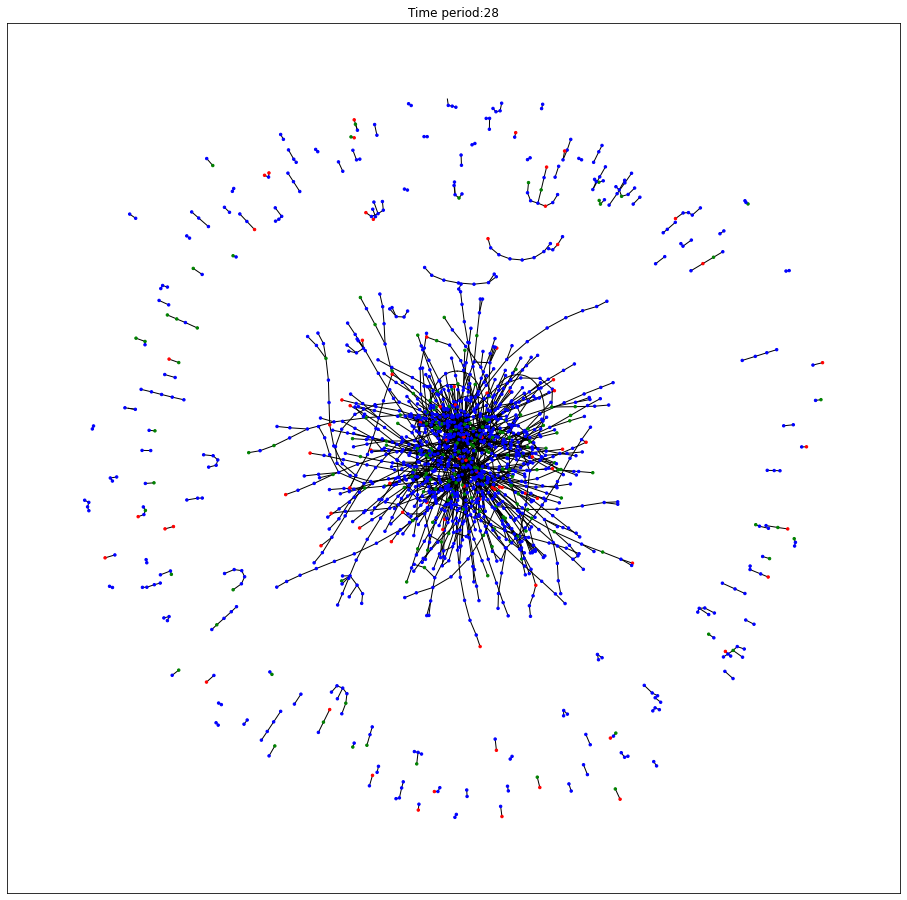

In [105]:
time_period=28
sub_node_list=df_merge.index[df_merge.loc[:,1]==time_period].tolist()

edge_tuples=[]
for row in data_train.edge_index.view(-1,2).numpy():
    if(row[0] in sub_node_list) | (row[1] in sub_node_list):
        edge_tuples.append(tuple(row))
len(edge_tuples)

node_color=[]

for node_id in sub_node_list:
    if node_id in classified_illicit_idx:
        label='red'
    elif node_id in classified_licit_idx:
        label='green'
    else:
        if output['pred_labels'][node_id]:
            label='orange'
        else:
            label='blue'
            
    node_color.append(label)
    
G=nx.Graph()
G.add_edges_from(edge_tuples)
    
plt.figure(3,figsize=(16,16))
plt.title('Time period:'+str(time_period))
# nx.draw_networkx(G, node_list=sub_node_list, node_color=node_color, node_size=6, with_labels=False)
nx.draw_networkx(G, nodelist=sub_node_list, node_color=node_color, node_size=6, with_labels=False)

In [106]:
model_name_list=["GATv2prebuilt.results","GATprebuilt.results"]
names = ["GATv2_prebuilt", "GAT_prebuilt"]

mm_list0=[load_results(fn) for fn in model_name_list]
plot_training_comp(mm_list0, names, 'aucroc', title='Val set aucroc comparison')



In [109]:
aucroc_l=[]
accuracy_l=[]
f1micro_l=[]
f1macro_l=[]
model_versions=[]

for c1, mm in enumerate(mm_list0):
    model_versions.append(names[c1])
    best=mm.get_best('aucroc')
    
    aucroc_l.append(best['aucroc'])
    accuracy_l.append(best['accuracy'])
    f1micro_l.append(best['f1micro'])
    f1macro_l.append(best['f1macro'])
    
d={"model_version": model_versions, "aucroc":aucroc_l, "accuracy": accuracy_l, "f1_macro": f1macro_l, "f1_micro": f1micro_l} 
df=pd.DataFrame(data=d)

In [110]:
df.round(3)

,model_version,aucroc,accuracy,f1_macro,f1_micro
0,GATv2_prebuilt,0.863,0.902,0.474,0.902
1,GAT_prebuilt,0.874,0.902,0.474,0.902
